## Importing the required libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2
import seaborn as sns
import pandas as pd

import tensorflow as tf
from PIL import Image , ImageEnhance

print(tf.__version__)
%matplotlib inline

2.11.0


## Part I: Data manipulation

### Data importing

Before proceding to the training steps, we load the training dataset and the validation set.

In [ ]:
#importing the training dataset
path_train='./data/boneage-training-dataset'
training_images=os.listdir(path_train)

#printing the number of images
print('the number of images in the training set:')
print(len(training_images))

#importing the validation dataset
path_val = './data/boneage-validation-dataset-1'
validation_images=os.listdir(path_val)

#number of validation images
print('\nthe number of images in the validation set:')
print(len(validation_images))

the number of images in the training set:
12611

the number of images in the validation set:
800


### Data visualising

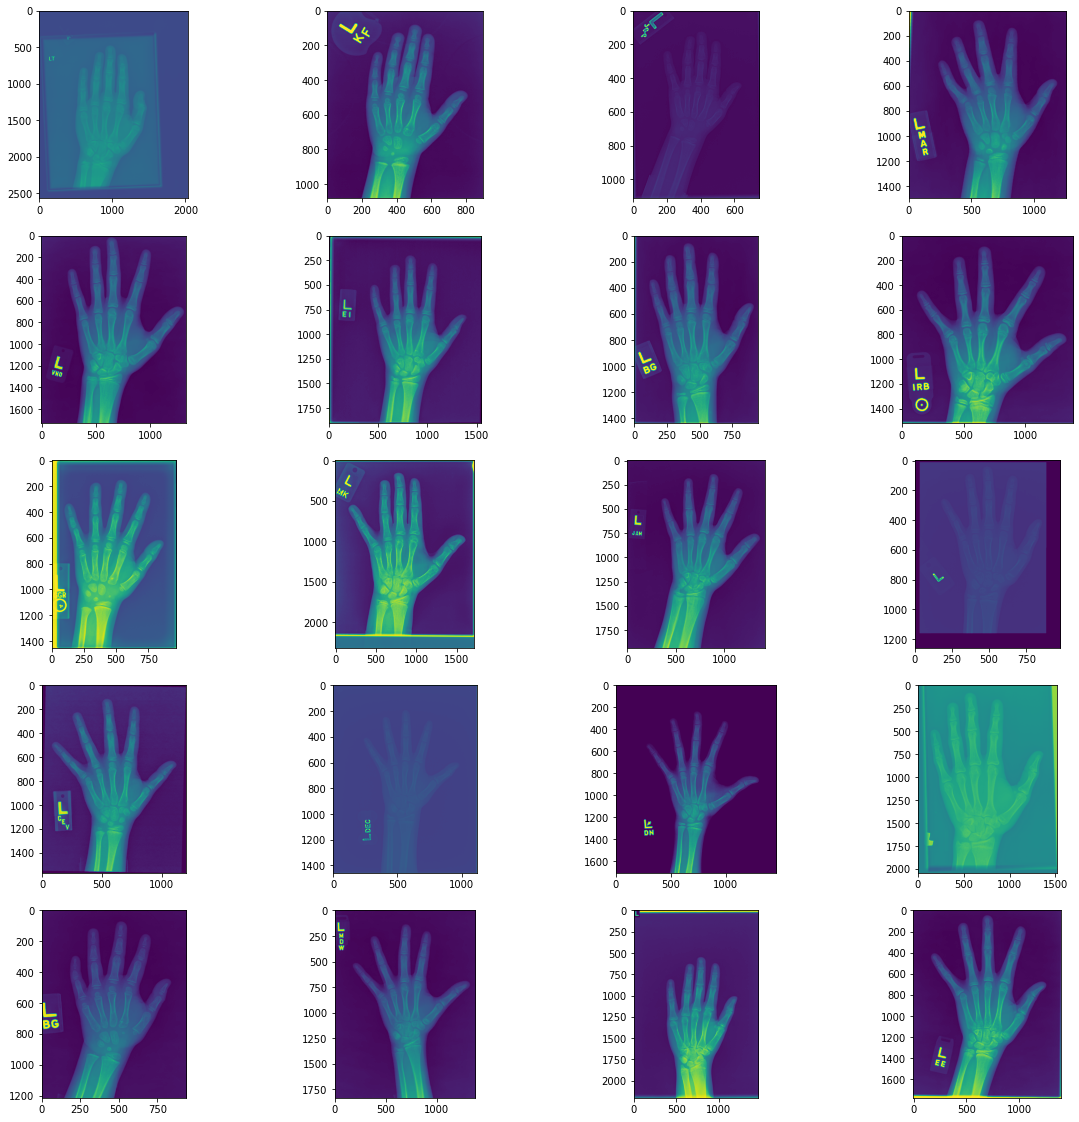

In [ ]:
#Plotting 20 images from the training set

fig=plt.figure(figsize=(20, 20))
col = 4 #colomns
rw = 5 #rows
for i in range(1, col*rw +1):
    img = plt.imread(path+"/"+training_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Data preprocessing

Before starting to analyse the data, we need to preprocess the dataset by resizing the images, enhancing the color and improving the contrast.

In [ ]:
def PreProcessingImage(path,images):
    # we do repeat the process for all the images in the dataset
  for img_path in images:
    image=Image.open(os.path.join(path,img_path))
    # we resize the images to a resolution 256x256. In a way that all images will be in the same size
    image=image.resize((256,256), Image.BICUBIC)

    # we improve the color of the image by enhancing the brightnes and most importantly the contrast of the image
    image_enhancer = ImageEnhance.Contrast(image)
    factor=1.5
    enhanced_image = image_enhancer.enhance(factor)

    # we turn the image into an array
    image_array = np.array(enhanced_image)

    # the package CLAHE solves the problem of losing some information by the global equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))
    img = clahe.apply(image_array)

    # the package Bilateral Filter smooths the images based on the spatial domain and the range domain.
    # In conclusion, it performs filtering and preserves the edges
    img = cv2.bilateralFilter(img, 3, 10, 10)

    # we convert back the array into image
    image = Image.fromarray(img)
    # we change the image coloring from gray scale to RBG
    image = image.convert('RGB')
    # finaly, wesave the new image
    image.save(os.path.join(path,img_path))

we apply the preprocessing function to both tthe training set and the validation set.

In [ ]:
#processing all the images in the training and validation list
PreProcessingImage(path,training_images)
PreProcessingImage(path_val,validation_images)

## Part II: Data Analysis

### Analysing the training set

In [ ]:
# we read the train DataFrame
df_train=pd.read_csv("./data/train.csv")

# we visualize the head of the dataframe
df_train.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [ ]:
# we apply a kind of mask on the male column to make it a binary form
# we attribute 1 for a male and 0 for a female
mapper={False : 0, True : 1}
df_train['male']=df_train['male'].map(mapper)

the number of males: 6833
the number of females: 5778


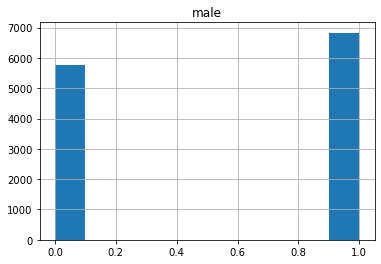

In [ ]:
# we create a graphic representation of the gender distribution
df_train.hist('male')
print('the number of males:', len(df_train[df_train['male'] == 1]))
print('the number of females:', len(df_train[df_train['male'] == 0]))

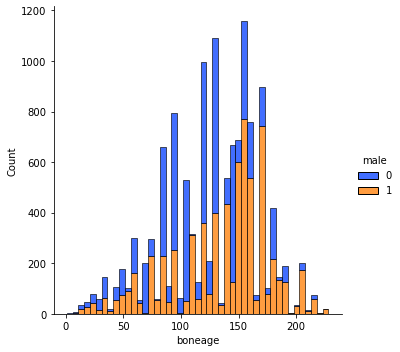

In [ ]:
# we plot the number of counts for each age for males and females
sns.set_palette("bright")
sns.displot(df_train,x='boneage',hue='male', multiple="stack")

##### Using the figure, we can decide how many classes we should consider for the classification task from the peaks

In [ ]:
# we examine the ages of the bones
# we use "unique" to get the unique values
list_Age=df_train['boneage'].unique()

# print the minimun, maximum and average bone age
print("The minimum age: ",min(list_Age),"\nthe maximum age: ",max(list_Age),"\nthe average age: ",np.mean(list_Age))

The minimum age:  1 
the maximum age:  228 
the average age:  108.94375


In [ ]:
# we create five classes that are evenly dispersed based on the age of the bones.
age_qcut=pd.qcut(df_train['boneage'],
                 q=5,
                 labels=False,
                 retbins=True,
                 duplicates='drop')

# we print the respective bins of the 5 classes
print(age_qcut[1])

[  1.  94. 120. 144. 162. 228.]


In [ ]:
# we add a new column with the bone age classifications
df_train['boneage_class']=pd.qcut(df_train['boneage'],
                                  q=5,
                                  labels=False,
                                  duplicates='drop')

# we examine the dataframe
df_train.head(10)

,id,boneage,male,boneage_class
0,1377,180,0,4
1,1378,12,0,0
2,1379,94,0,0
3,1380,120,1,1
4,1381,82,0,0
5,1382,138,1,2
6,1383,150,1,3
7,1384,156,1,3
8,1385,36,1,0
9,1387,138,1,2


In [ ]:
# we append the '.png' extension to the image's id
df_train['id']=df_train['id'].apply(lambda id : str(id)+'.png')

In [ ]:
# tensorflow's ImageDataLoader requires string type.
# As a result, we updated the data type to str.
df_train['boneage_class']=df_train['boneage_class'].astype('str')

# we get a final look of the data
df_train.head(10)

,id,boneage,male,boneage_class
0,1377.png,180,0,4
1,1378.png,12,0,0
2,1379.png,94,0,0
3,1380.png,120,1,1
4,1381.png,82,0,0
5,1382.png,138,1,2
6,1383.png,150,1,3
7,1384.png,156,1,3
8,1385.png,36,1,0
9,1387.png,138,1,2


### Analysing the validation set

In [ ]:
# we read the validation DataFrame
df_valid=pd.read_csv("./data/Validation Dataset.csv")

# we visualize the head of the dataframe
df_valid.head()

,Image ID,male,Bone Age (months)
0,1386,False,30
1,1392,True,162
2,1397,False,18
3,1401,False,132
4,1410,True,57


In [ ]:
# we apply the same mapper to the validation set
mapper={False : 0, True : 1}
df_valid['male']=df_valid['male'].map(mapper)

# we transform the validation set to get the same format as the training set
df_valid['boneage']=df_valid['Bone Age (months)']

# we use the same bins as the training to build the bone age classes.
labels=[i for i in range(len(age_qcut[1])-1)]
df_valid['boneage_class']=pd.cut(df_valid['boneage'],
                               bins=age_qcut[1],
                               labels=labels,
                               retbins=False).astype(str)

In [ ]:
# we append the '.png' extension to the image's id
df_valid['id']=df_valid['Image ID'].apply(lambda id : str(id)+'.png')

# drop unwanted columns
df_valid=df_valid.drop(['Image ID','Bone Age (months)'],axis=1)

# we get a final look of the data
df_valid.head(10)

,male,boneage,boneage_class,id
0,0,30,0,1386.png
1,1,162,3,1392.png
2,0,18,0,1397.png
3,0,132,2,1401.png
4,1,57,0,1410.png
5,1,150,3,1413.png
6,1,24,0,1421.png
7,0,120,1,1449.png
8,1,16,0,1450.png
9,1,120,1,1456.png


## Part III: Data modeling

### Feature extraction

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#ImageDataGenerator Generates batches of tensor image data with real-time data augmentation.

training_data_generator=ImageDataGenerator(
                                rescale=1/255.,  #we multiply the data by the value provided
                                rotation_range=15, #Degree range for random rotations
                                zoom_range=0.2, #Range for random zoom.
                                )
validation_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                )

In [ ]:
#Takes the dataframe and the path to a directory + generates batches.
#The generated batches contain augmented/normalized data.
#we are focusing on the id and the boneage class
def DataGenerator(generator,df,directory,target_size=(256,256),batch_size=64,seed=40,x_col="id",y_col='boneage_class'):
  df = df.sample(frac=1).reset_index(drop=True)
  data=generator.flow_from_dataframe(df,
                                     #Path to the directory which contains all the images.
                                     directory=directory,
                                     #The name of the column which contains the filenames of the images.
                                     x_col=x_col,
                                     #the column which contains the class names.
                                     y_col=y_col,
                                      # The dimensions to which all images found will be resized
                                     target_size=target_size,
                                     #size of the batches of data
                                     batch_size=batch_size,
                                     #2D numpy array of one-hot encoded labels. Supports multi-label output.
                                     class_mode='categorical',
                                     #to yield the images in order
                                     shuffle=False,
                                     #Whether the images will be converted to have 1 or 3 color channels.
                                     color_mode="rgb"
                                     )
  return data

In [ ]:
# splitting the validation data to test and validation
from sklearn.model_selection import train_test_split
df_valid,df_test=train_test_split(df_valid,test_size=0.1,stratify=df_valid['boneage_class'].values.astype(int))

In [ ]:
#apply the datageneration function to both train and validation data
train_data=DataGenerator(training_data_generator,df_train,directory='./data/boneage-training-dataset')
valid_data=DataGenerator(validation_data_generator,df_valid,directory='./data/boneage-validation-dataset-1')

Found 12611 validated image filenames belonging to 5 classes.
Found 721 validated image filenames belonging to 5 classes.


C:\ana\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 561 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


### Building the CNN model

In [ ]:
#build our own model
def customized_model(num_class):
    model = tf.keras.Sequential([
        #an entry point layer into the Network
        tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),

        #2D convolution layer
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #2D convolution layer
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #Max pooling operation for 2D spatial data
        tf.keras.layers.MaxPool2D(),

        #first convolutional block with 32 filters
        #Depthwise separable 2D convolution.
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        #Layer that normalizes its inputs.
        tf.keras.layers.BatchNormalization(),
        #Max pooling operation for 2D spatial data
        tf.keras.layers.MaxPool2D(),

        #second convolutional block with 64 filters
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        #Layer that normalizes its inputs.
        tf.keras.layers.BatchNormalization(),
        #Max pooling operation for 2D spatial data
        tf.keras.layers.MaxPool2D(),

        #third convolutional block with 128 filters
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        #Layer that normalizes its inputs.
        tf.keras.layers.BatchNormalization(),
        #Max pooling operation for 2D spatial data
        tf.keras.layers.MaxPool2D(),

        #Applies Dropout to the input with 0.2 being the Fraction of the input units to drop
        tf.keras.layers.Dropout(0.2),

        #last convolutional block with 256 filters
        tf.keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        #Layer that normalizes its inputs.
        tf.keras.layers.BatchNormalization(),
        #Max pooling operation for 2D spatial data
        tf.keras.layers.MaxPool2D(),

        #Applies Dropout to the input with 0.2 being the Fraction of the input units to drop
        tf.keras.layers.Dropout(0.2),

        #Flattens the input. Does not affect the batch size.
        tf.keras.layers.Flatten(),

        #First Dense block 512 units and a dropout rate of 0.7
        tf.keras.layers.Dense(512, activation='relu'), # regular densely-connected NN layer
        #Layer that normalizes its inputs.
        tf.keras.layers.BatchNormalization(),
        #Applies Dropout to the input with 0.7 being the Fraction of the input units to drop
        tf.keras.layers.Dropout(0.7),

        #Second Dense block 128 units and a dropout rate of 0.5
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        #Last  Dense block 64 units and a dropout rate of 0.3
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        #regular densely-connected NN layer
        tf.keras.layers.Dense(num_class, activation='softmax')
    ])

    return model

In [ ]:
#initializing our model with 5 classes
model = customized_model(5)
model.compile(
    # Optimizer that implements the Adam algorithm which is a replacement optimization
    # algorithm for stochastic gradient descent for training deep learning models.
    optimizer='adam',
    #minimizes the distance between he probabilities of reality and prediction
    loss='binary_crossentropy',
    # List of metrics to be evaluated by the model during training and testing.
    metrics=[
    'accuracy',
    #Computes the precision of the predictions with respect to the labels
    tf.keras.metrics.Precision(name='precision'),
    #Computes the recall of the predictions with respect to the labels
    tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# we reduce learning rate when a metric has stopped improving, in this case we are monitoring the val loss
learningRate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                              patience=4,
                                                              factor=0.2,
                                                              mode='min',
                                                              min_delta=1e-4,
                                                              verbose=1)

#we stop training when a monitored metric has stopped improving, in this case we are monitoring the val loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                           patience=3,
                                                           mode='min',
                                                           verbose=1)

#Callback to save the  model weights
save_best = tf.keras.callbacks.ModelCheckpoint('./data/data_analytics.hdf5',
                                               monitor="loss",
                                               mode='min',
                                               verbose=1,
                                               save_best_only=True)

In [ ]:
#defining  function that applies exponential decay to the learning rate.

def exponential_learning_rate_decay(lr0, s):
    def exponential_learning_rate_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_learning_rate_decay_fn


In [ ]:
exponential_learning_rate_decay_fn = exponential_learning_rate_decay(0.001, 20)
# we fixed the final value to 0.001.

# we update learning rate value and applies the updated learning rate on the optimizer.
learningRate_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_learning_rate_decay_fn)
callback=[learningRate_scheduler,save_best,early_stopping]

In [ ]:
# we start the training
# we define the desired batch size
batch_size=64
with tf.device('/CPU:0'):
  history = model.fit_generator(
    generator=train_data,
    # we specifie the total number of steps taken from the generator
    # as soon as one epoch is finished and next epoch has started
    steps_per_epoch=df_train.shape[0] // batch_size + 1,
    validation_data=valid_data,
    # total number of steps taken from the generator before it
    # is stopped at every epoch
    validation_steps=df_valid.shape[0] // batch_size + 1,
    epochs=20,
    callbacks=callback
  )

C:\Users\HANENH~1\AppData\Local\Temp/ipykernel_8732/2553590318.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.2158 - precision: 0.2266 - recall: 0.0652WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 21 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: loss improved from inf to 0.70556, saving model to ./data\data_analytics.hdf5
198/198 [==============================] - 742s 4s/step - loss: 0.7056 - accuracy: 0.2158 - precision: 0.2266 - recall: 0.0652 - val_loss: 0.5303 - val_accuracy: 0.2386 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
198/198 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.2177 - precision: 0.2223 - recall: 0.0213
Epoch 2: loss improved from 0.70556 to 0.54789, saving model to ./data\data_analytics.hdf5
198/198 [==============================] - 658s 3s/step

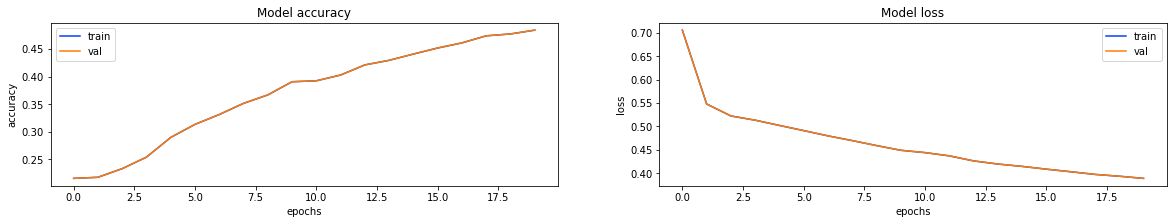

In [ ]:
#plot the results of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Part IV: Tunning the model

### Efficient Net B0
The EfficientNet model is an extension to CNN with using a compound coefficient. The scaling operation is uniform applying fixed scaling coefficients on width, depth and resolution all together with maintaining a balance. This scaling method helps to capture more patterns on big images like the radiographs. EfficientNet is not only lightweight and faster than other models but it also provides a higher accuracy.

In [ ]:
#import the necessary libraries

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
#ImageDataGenerator Generates batches of tensor image data with real-time data augmentation.
training_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                rotation_range=15,
                                zoom_range=0.2,
                                preprocessing_function=preprocess_input)
validation_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                preprocessing_function=preprocess_input)

In [ ]:
#Takes the dataframe and the path to a directory + generates batches.
#The generated batches contain augmented/normalized data.
#we were focusing only on the id and the boneage class
#but now we are introducing the gender feature
def DataGenerator(generator,df,directory,target_size=(256,256),batch_size=64,seed=40,x_col="id",y_col='boneage_class'):
  df = df.sample(frac=1).reset_index(drop=True)
  train_data=generator.flow_from_dataframe(df,
                                             directory=directory,
                                             x_col=x_col,
                                             y_col=y_col,
                                             target_size=target_size,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=False,
                                             color_mode="rgb"
                                             )
  dataset = tf.data.Dataset.from_tensor_slices((df['male'])) #Creates a Dataset whose elements are slices of the given tensors in this case it's the gender
  dataset = dataset.batch(64) #create batches
  iteretor = iter(dataset)
  while True :
    X=train_data.next()
    try:
      gender=iteretor.get_next()
    except :
      iteretor = iter(dataset)
      gender=iteretor.get_next()
    gender=gender[:,np.newaxis]
    yield [X[0],gender],X[1] #return ur new dataset tht includes the gender

In [ ]:
#apply the datageneration function to train, validation and test data
train_data=DataGenerator(training_data_generator,df_train,directory='./data/boneage-training-dataset')
valid_data=DataGenerator(validation_data_generator,df_valid,directory='./data/boneage-validation-dataset-1')
test_data=DataGenerator(validation_data_generator,df_test,directory='./data/boneage-validation-dataset-1')

In [ ]:
#defining the model
def EfficientNetB0Model(input_shape,num_class):
  inputs=tf.keras.Input(shape=input_shape)
  base_model=EfficientNetB0(include_top=False,#Whether to include the fully-connected layer at the top of the network
                            input_tensor=inputs, # use as image input for the model
                            weights="imagenet",)#pre-training on ImageNet

  base_model.trainable=True #Unfreeze the base model

  # Create new model on top
  x = base_model.output #take the output of the existing model to build on top of
  x = tf.keras.layers.GlobalAveragePooling2D()(x)#add a pooling layer

  #take the gender as new input to our NN
  gender_input = tf.keras.Input(shape=(1),name="gender_feature")

  #Apply some transformation to the new input layer
  x_gender=tf.keras.layers.Dense(64,activation="relu")(gender_input)
  x_gender=tf.keras.layers.BatchNormalization()(x_gender)
  x_gender=tf.keras.layers.Dropout(0.3)(x_gender)

  #concat the new the input layer to the existing output layer of the old NN
  x = tf.keras.layers.concatenate([x,x_gender],axis=1,name="concat")

  #Apply some more transformation to the concatinated input layer
  x = tf.keras.layers.Dense(256,activation="relu")(x)
  x =tf.keras.layers.BatchNormalization()(x)
  x =tf.keras.layers.Dropout(0.3)(x)

  #create the new  output consisting of 5 classes
  outputs = tf.keras.layers.Dense(num_class,activation="softmax")(x)
  model = tf.keras.Model(inputs=[inputs,gender_input], outputs=outputs)
  model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
  return model

In [ ]:
input_shape=(256,256,3)#define the input shape
num_class=5#define the number of classes
model=EfficientNetB0Model(input_shape,num_class)#create the model

In [ ]:
# print a useful summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 256, 256, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_3[0][0]            
______________________________________________________________________________________________

In [ ]:
#Reduce learning rate when a metric has stopped improving, in this case we are monitoring the val loss
learningRate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.2,mode='min',min_delta=1e-4,verbose=1)

#Stop training when a monitored metric has stopped improving, in this case we are monitoring the val loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,mode='min',verbose=1)

#Callback to save the  model weights
save_best = tf.keras.callbacks.ModelCheckpoint('/content/data_analytics_efficientnet.hdf5',monitor="val_loss",save_weights_only=True,mode='min',verbose=1,save_best_only=True)
callback=[learningRate_scheduler,save_best,early_stopping]

In [ ]:
#start training
batch_size=64#define desired batch size
with tf.device('/GPU:0'):
  history=model.fit_generator(generator=train_data,
                    steps_per_epoch=df.shape[0] // batch_size + 1,#it specifies the total number of steps taken from the generator
                                                                  #as soon as one epoch is finished and next epoch has started
                    validation_data=val_data,
                    validation_steps=df_val.shape[0] // batch_size + 1,# total number of steps taken from the generator before it
                                                                       #is stopped at every epoch
                    epochs=40,
                    verbose=1,
                    callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 12611 validated image filenames belonging to 5 classes.
Epoch 1/40
198/198 [==============================] - 258s 1s/step - loss: 1.0532 - accuracy: 0.5789 - val_loss: 1.7227 - val_accuracy: 0.2301

Epoch 00001: val_loss improved from inf to 1.72268, saving model to /content/data_analytics_efficientnet.hdf5
Epoch 2/40
198/198 [==============================] - 217s 1s/step - loss: 0.7287 - accuracy: 0.6810 - val_loss: 1.7542 - val_accuracy: 0.2473

Epoch 00002: val_loss did not improve from 1.72268
Epoch 3/40
198/198 [==============================] - 214s 1s/step - loss: 0.6692 - accuracy: 0.7122 - val_loss: 1.6939 - val_accuracy: 0.2816

Epoch 00003: val_loss improved from 1.72268 to 1.69386, saving model to /content/data_analytics_efficientnet.hdf5
Epoch 4/40
198/198 [==============================] - 215s 1s/step - loss: 0.6373 - accuracy: 0.7274 - val_loss: 1.3190 - val_accuracy: 0.3885

Epoch 00004: val_loss improved from 1.69386 to 1.31897, saving model to /content/data_a

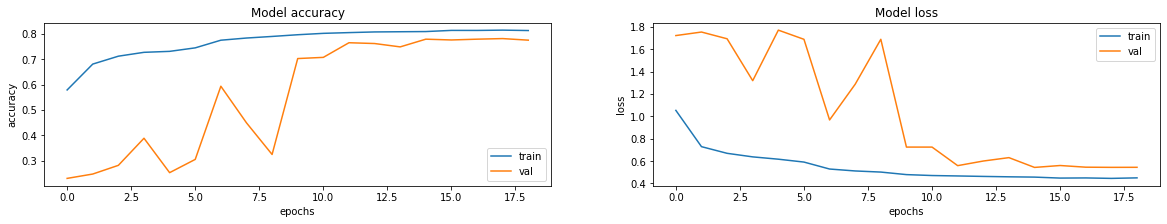

In [ ]:
#plot the results of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#evaluating the model performance on the test set
scores=model.evaluate_generator(test_data,steps=df_test.shape[0]//65)
print(f" test scores :{scores}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 143 validated image filenames belonging to 5 classes.
 test scores :[0.5604656934738159, 0.7421875]


### Inception V3
The Inception model is another extension to CNN for image analysis and it got the name from ”going deeper” from the inception movie. The inception layer is composed by 1x1, 3x3 and 5x5 convolution layers plus a max pooling layer. Inception performs an efficient computation with deeper extraction by reducing the dimension. The final outputs are concatenated are concatenated and transferred together to the next layer.

In [ ]:
#import the necessary libraries
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3

In [ ]:
#ImageDataGenerator Generates batches of tensor image data with real-time data augmentation.
training_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                rotation_range=15,
                                zoom_range=0.2,
                                preprocessing_function=preprocess_input)
validation_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                preprocessing_function=preprocess_input)

In [ ]:
#Takes the dataframe and the path to a directory + generates batches.
#The generated batches contain augmented/normalized data.
#we were focusing only on the id and the boneage class
#but now we are introducing the gender feature
def DataGenerator(generator,df,directory,target_size=(256,256),batch_size=64,seed=40,x_col="id",y_col='boneage_class'):
  df = df.sample(frac=1).reset_index(drop=True)
  train_data=generator.flow_from_dataframe(df,
                                             directory=directory,
                                             x_col=x_col,
                                             y_col=y_col,
                                             target_size=target_size,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=False,
                                             color_mode="rgb"
                                             )
  dataset = tf.data.Dataset.from_tensor_slices((df['male'])) #Creates a Dataset whose elements are slices of the given tensors in this case it's the gender
  dataset = dataset.batch(64)#create batches
  iteretor = iter(dataset)
  while True :
    X=train_data.next()
    try:
      gender=iteretor.get_next()
    except :
      iteretor = iter(dataset)
      gender=iteretor.get_next()
    gender=gender[:,np.newaxis]
    yield [X[0],gender],X[1] #return ur new dataset tht includes the gender

In [ ]:
#apply the datageneration function to train, validation and test data
train_data=DataGenerator(training_data_generator,df_train,directory='./data/boneage-training-dataset')
valid_data=DataGenerator(validation_data_generator,df_valid,directory='./data/boneage-validation-dataset-1')
test_data=DataGenerator(validation_data_generator,df_test,directory='./data/boneage-validation-dataset-1')

In [ ]:
#defining the model
def InceptionV3Model(input_shape,num_class):
  inputs=tf.keras.Input(shape=input_shape)
  base_model=InceptionV3(include_top=False,#Whether to include the fully-connected layer at the top of the network
                         input_tensor=inputs, # use as image input for the model
                         weights="imagenet",)#pre-training on ImageNet

  base_model.trainable=True  #Unfreeze the base model

  # Create new model on top
  x = base_model.output #take the output of the existing model to build on top of
  x = tf.keras.layers.GlobalAveragePooling2D()(x) #add a pooling layer

  #take the gender as new input to our NN
  gender_input = tf.keras.Input(shape=(1),name="gender_feature")

  #Apply some transformation to the new input layer
  x_gender= tf.keras.layers.Dense(64,activation="relu")(gender_input)
  x_gender=tf.keras.layers.BatchNormalization()(x_gender)
  x_gender=tf.keras.layers.Dropout(0.3)(x_gender)

  #concat the new the input layer to the existing output layer of the old NN
  x = tf.keras.layers.concatenate([x,x_gender],axis=1,name="concat")

  #Apply some more transformation to the concatinated input layer
  x = tf.keras.layers.Dense(256,activation="relu")(x)
  x =tf.keras.layers.BatchNormalization()(x)
  x =tf.keras.layers.Dropout(0.3)(x)

  #create the new  output consisting of 5 classes
  outputs = tf.keras.layers.Dense(num_class,activation="softmax")(x)
  model = tf.keras.Model(inputs=[inputs,gender_input], outputs=outputs)
  model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
  return model

In [ ]:
input_shape=(256,256,3)#define the input shape
num_class=5#define the number of classes
model=InceptionV3Model(input_shape,num_class)#create the model

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# print a useful summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Reduce learning rate when a metric has stopped improving, in this case we are monitoring the val loss
learningRate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.2,mode='min',min_delta=1e-4,verbose=1)

#Stop training when a monitored metric has stopped improving, in this case we are monitoring the val loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,mode='min',verbose=1)

#Callback to save the  model weights
save_best = tf.keras.callbacks.ModelCheckpoint('/content/data_analytics_Inception.hdf5',monitor="val_loss",save_weights_only=True,mode='min',verbose=1,save_best_only=True)
callback=[learningRate_scheduler,save_best,early_stopping]

In [ ]:
#start training
batch_size=64 #define desired batch size
with tf.device('/GPU:0'):
  history=model.fit_generator(generator=train_data,
                    steps_per_epoch=df.shape[0] // batch_size + 1,#it specifies the total number of steps taken from the generator
                                                                  #as soon as one epoch is finished and next epoch has started
                    validation_data=val_data,
                    validation_steps=df_val.shape[0] // batch_size + 1,# total number of steps taken from the generator before it
                                                                       #is stopped at every epoch
                    epochs=40,
                    verbose=1,
                    callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 12611 validated image filenames belonging to 5 classes.
Epoch 1/40
198/198 [==============================] - 261s 1s/step - loss: 0.9595 - accuracy: 0.6080 - val_loss: 1.6960 - val_accuracy: 0.1919

Epoch 00001: val_loss improved from inf to 1.69599, saving model to /content/data_analytics_Inception.hdf5
Epoch 2/40
198/198 [==============================] - 211s 1s/step - loss: 0.6995 - accuracy: 0.6995 - val_loss: 0.9872 - val_accuracy: 0.5640

Epoch 00002: val_loss improved from 1.69599 to 0.98718, saving model to /content/data_analytics_Inception.hdf5
Epoch 3/40
198/198 [==============================] - 211s 1s/step - loss: 0.6698 - accuracy: 0.7180 - val_loss: 4.2465 - val_accuracy: 0.5156

Epoch 00003: val_loss did not improve from 0.98718
Epoch 4/40
198/198 [==============================] - 262s 1s/step - loss: 0.6438 - accuracy: 0.7279 - val_loss: 0.8271 - val_accuracy: 0.6732

Epoch 00004: val_loss improved from 0.98718 to 0.82706, saving model to /content/data_analyti

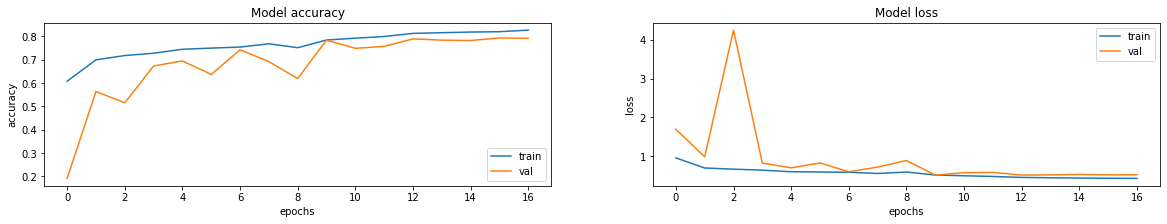

In [ ]:
#plot the results of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#evaluating the model performance on the test set
scores=model.evaluate_generator(test_data,steps=df_test.shape[0]//65)
print(f" test scores :{scores}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 143 validated image filenames belonging to 5 classes.
 test scores :[0.5134238600730896, 0.828125]


### Resnet 50
The Resnet is formed by residual blocks that varies from one architecture to another. it's used to solve complex problems by adding more layers that help to extract more information. The block is characterized by direct linking which helps skipping some connections which will modify the value of the output. This strategy helps allowing the model to learn the functions which ensuring that the high level layers will give a result similar to the lower layer.

In [ ]:
#import the necessary libraries
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

In [ ]:
#ImageDataGenerator Generates batches of tensor image data with real-time data augmentation.
training_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                rotation_range=15,
                                zoom_range=0.2,
                                preprocessing_function=preprocess_input)
validation_data_generator=ImageDataGenerator(
                                rescale=1/255.,
                                preprocessing_function=preprocess_input)

In [ ]:
#Takes the dataframe and the path to a directory + generates batches.
#The generated batches contain augmented/normalized data.
#we were focusing only on the id and the boneage class
#but now we are introducing the gender feature
def DataGenerator(generator,df,directory,target_size=(256,256),batch_size=64,seed=40,x_col="id",y_col='boneage_class'):
  df = df.sample(frac=1).reset_index(drop=True)
  train_data=generator.flow_from_dataframe(df,
                                             directory=directory,
                                             x_col=x_col,
                                             y_col=y_col,
                                             target_size=target_size,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=False,
                                             color_mode="rgb"
                                             )
  dataset = tf.data.Dataset.from_tensor_slices((df['male']))#Creates a Dataset whose elements are slices of the given tensors in this case it's the gender
  dataset = dataset.batch(64)#create batches
  iteretor = iter(dataset)
  while True :
    X=train_data.next()
    try:
      gender=iteretor.get_next()
    except :
      iteretor = iter(dataset)
      gender=iteretor.get_next()
    gender=gender[:,np.newaxis]
    yield [X[0],gender],X[1]#return ur new dataset tht includes the gender

In [ ]:
#apply the datageneration function to train, validation and test data
train_data=DataGenerator(training_data_generator,df_train,directory='./data/boneage-training-dataset')
valid_data=DataGenerator(validation_data_generator,df_valid,directory='./data/boneage-validation-dataset-1')
test_data=DataGenerator(validation_data_generator,df_test,directory='./data/boneage-validation-dataset-1')

In [ ]:
#defining the model
def ResNet50Model(input_shape,num_class):
  inputs=tf.keras.Input(shape=input_shape)
  base_model=ResNet50(include_top=False,#Whether to include the fully-connected layer at the top of the network
                         input_tensor=inputs, # use as image input for the model
                         weights="imagenet",)#pre-training on ImageNet

  base_model.trainable=True#Unfreeze the base model

  # Create new model on top
  x = base_model.output #take the output of the existing model to build on top of
  x = tf.keras.layers.GlobalAveragePooling2D()(x)#add a pooling layer

  #take the gender as new input to our NN
  gender_input = tf.keras.Input(shape=(1),name="gender_feature")

  #Apply some transformation to the new input layer
  x_gender= tf.keras.layers.Dense(64,activation="relu")(gender_input)
  x_gender=tf.keras.layers.BatchNormalization()(x_gender)
  x_gender=tf.keras.layers.Dropout(0.3)(x_gender)

  #concat the new the input layer to the existing output layer of the old NN
  x = tf.keras.layers.concatenate([x,x_gender],axis=1,name="concat")

  #Apply some more transformation to the concatinated input layer
  x = tf.keras.layers.Dense(256,activation="relu")(x)
  x =tf.keras.layers.BatchNormalization()(x)
  x =tf.keras.layers.Dropout(0.3)(x)

  #create the new  output consisting of 5 classes
  outputs = tf.keras.layers.Dense(num_class,activation="softmax")(x)
  model = tf.keras.Model(inputs=[inputs,gender_input], outputs=outputs)
  model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
  return model

In [ ]:
input_shape=(256,256,3)#define the input shape
num_class=5#define the number of classes
model=ResNet50Model(input_shape,num_class)#create the model

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
# print a useful summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Reduce learning rate when a metric has stopped improving, in this case we are monitoring the val loss
learningRate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.2,mode='min',min_delta=1e-4,verbose=1)

#Stop training when a monitored metric has stopped improving, in this case we are monitoring the val loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,mode='min',verbose=1)

#Callback to save the  model weights
save_best = tf.keras.callbacks.ModelCheckpoint('/content/data_analytics_resnet.hdf5',monitor="val_loss",save_weights_only=True,mode='min',verbose=1,save_best_only=True)
callback=[learningRate_scheduler,save_best,early_stopping]

In [ ]:
#start training
batch_size=64 #define desired batch size
with tf.device('/GPU:0'):
  history=model.fit_generator(generator=train_data,
                    steps_per_epoch=df.shape[0] // batch_size + 1,#it specifies the total number of steps taken from the generator
                                                                  #as soon as one epoch is finished and next epoch has started
                    validation_data=val_data,
                    validation_steps=df_val.shape[0] // batch_size + 1,# total number of steps taken from the generator before it
                                                                       #is stopped at every epoch
                    epochs=40,
                    verbose=1,
                    callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 12611 validated image filenames belonging to 5 classes.
Epoch 1/40
198/198 [==============================] - 228s 1s/step - loss: 1.0034 - accuracy: 0.5896 - val_loss: 2.0070 - val_accuracy: 0.2402

Epoch 00001: val_loss improved from inf to 2.00699, saving model to /content/data_analytics_resnet.hdf5
Epoch 2/40
198/198 [==============================] - 220s 1s/step - loss: 0.7382 - accuracy: 0.6819 - val_loss: 2.5485 - val_accuracy: 0.2402

Epoch 00002: val_loss did not improve from 2.00699
Epoch 3/40
198/198 [==============================] - 252s 1s/step - loss: 0.7023 - accuracy: 0.6999 - val_loss: 1.3367 - val_accuracy: 0.4680

Epoch 00003: val_loss improved from 2.00699 to 1.33668, saving model to /content/data_analytics_resnet.hdf5
Epoch 4/40
198/198 [==============================] - 219s 1s/step - loss: 0.7087 - accuracy: 0.6936 - val_loss: 1.2248 - val_accuracy: 0.4750

Epoch 00004: val_loss improved from 1.33668 to 1.22485, saving model to /content/data_analytics_res

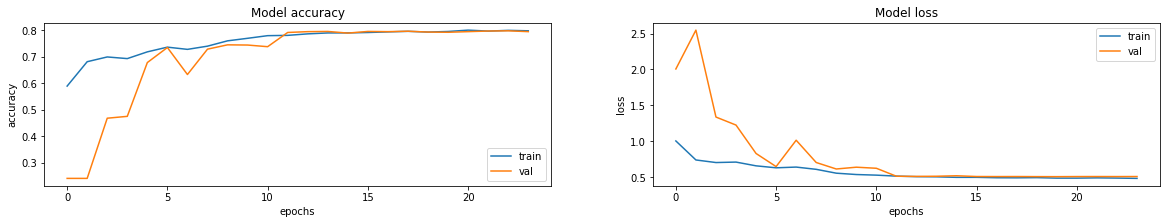

In [ ]:
#plot the results of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#evaluating the model performance on the test set
scores=model.evaluate_generator(test_data,steps=df_test.shape[0]//65)
print(f" test scores :{scores}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 143 validated image filenames belonging to 5 classes.
 test scores :[0.490781307220459, 0.7578125]
